In [1]:

import os.path as osp
shared_folder = osp.abspath(osp.join('..', '..', 'share'))
import sys
if shared_folder not in sys.path: sys.path.insert(1, shared_folder)
from notebook_utils import NotebookUtilities
nu = NotebookUtilities(
    data_folder_path=osp.abspath(osp.join('..', 'data')),
    saves_folder_path=osp.abspath(osp.join('..', 'saves'))
)

# Import needed libraries
%pprint
%matplotlib inline

executable_path = sys.executable; scripts_folder = osp.join(osp.dirname(executable_path), 'Scripts')
py_folder = osp.abspath(osp.join('..', 'py'))
if (scripts_folder not in sys.path): sys.path.insert(1, scripts_folder)
if (py_folder not in sys.path): sys.path.insert(1, py_folder)

print([f'nu.{fn}' for fn in dir(nu) if 'soup' in fn])

import os
from pandas import DataFrame, Series
import re

Pretty printing has been turned OFF
['nu.get_page_soup']


In [2]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.preprocessing import MultiLabelBinarizer


## Step 1: Load whatever CSS properties are left in the &lt;style&gt; tags in the SVG

In [4]:

file_path = osp.abspath('../data/svg/scratchpad.svg')
# file_path = osp.abspath(r'C:\Users\daveb\OneDrive\Pictures\Memes\Demopublicans_switching_corners.svg')
page_soup = nu.get_page_soup(file_path)
styles = []
labels = []
for tag in page_soup.find_all(attrs={"style": True, 'id': True}):
    
    # List of CSS styles
    tag_set = set([css_style.strip() for css_style in tag.get('style', '').split(';') if css_style.strip()])
    styles.append(tag_set)
    
    # List of style identifiers
    tag_id = tag.get('id', '').strip()
    labels.append(tag_id)

# Assertion to check if the lengths of both lists are equal
assert len(styles) == len(labels), 'You need to figure out why your search results for style="[^"]+" don\'t match up'
assert labels, "You need some labels to work with"


----
# Use a Decision Tree Classifier


## Step 2: Prepare the data

In [166]:

# Use MultiLabelBinarizer to one-hot encode the CSS properties
mlb = MultiLabelBinarizer()
X = mlb.fit_transform(styles)  # Features (one-hot encoded CSS properties)
feature_names = mlb.classes_  # CSS property names

# Create a target variable (y) for classification: encode the labels as integers
# y, string_to_integer_map = nu.convert_strings_to_integers(labels)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

array([], dtype=int64)


## Step 3: Train the Decision Tree Classifier

In [ ]:

# Train the Decision Tree Classifier
clf = DecisionTreeClassifier(criterion="entropy", random_state=42)
clf.fit(X, y)

# Rename the classes as labels
# integer_to_string_map = {v: k for k, v in string_to_integer_map.items()}
# clf.classes_ = np.array([integer_to_string_map[i] for i in clf.classes_])
clf.classes_ = np.array(labels)


## Step 4: Create a class of the CSS properties that always appear along side the Most Important Feature

In [ ]:

# Get the most important feature
important_feature = max([(feature_name, importance) for feature_name, importance in zip(feature_names, clf.feature_importances_)], key=lambda x: x[1])[0]

# Get the columns
df = DataFrame(X, columns=feature_names, index=labels)
mask_series = (df[important_feature] == 1)
srs = df[mask_series].sum()
max_count = srs.max() # Assume here that important_feature is among those features that have max count
mask_series = (srs == max_count)
columns_list = srs[mask_series].index.tolist()

In [ ]:

# Print out what goes in the <style> tag
print()
print('      .most-important-style {')
for cn in columns_list:
    print(f"""        {cn.replace(':', ': ')};""")
print('      }')

# Get the indices
mask_series = True
for cn in columns_list:
    mask_series &= (df[cn] == 1)
indices_list = df[mask_series].index.tolist()

# Print out the class name and the regex to find the IDs
print()
labels_str = '|'.join(sorted(indices_list))
print(r'id="(' + labels_str + r')"')
print()
print('class="most-important-style"')

# Print out the delete-able CSS properties regex
print()
props_str = '|'.join([re.sub(r"([]\[{}()*+?.\\^$|])", r"\\\g<1>", cn) for cn in sorted(columns_list)])
print(r'(' + props_str + r');?')


## Bonus: Output the decision tree as text

In [7]:

sorted(set.union(*styles))

['color:#000000', 'display:inline', 'fill-opacity:0.75', 'fill-opacity:1', 'fill-rule:evenodd', 'fill-rule:nonzero', 'fill:#000000', 'fill:#2e3436', 'fill:#eeeeec', 'fill:#ffffff', 'fill:none', 'fill:url(#aigrd2-2)', 'fill:url(#linearGradient2132)', 'fill:url(#linearGradient2289)', 'fill:url(#linearGradient2343)', 'fill:url(#linearGradient2347)', 'fill:url(#linearGradient7678)', 'fill:url(#linearGradient7684)', 'fill:url(#linearGradient7686)', 'fill:url(#linearGradient7688)', 'fill:url(#radialGradient2297)', 'fill:url(#radialGradient2714)', 'fill:url(#radialGradient2714-0)', 'fill:url(#radialGradient3279)', 'fill:url(#radialGradient7780-8)', 'fill:url(#radialGradient7786-4)', 'fill:url(#radialGradient7790-7)', 'fill:url(#radialGradient7796-9)', 'marker-end:none', 'marker-mid:none', 'marker-start:none', 'marker:none', 'opacity:0.17525802', 'opacity:0.18181817', 'opacity:0.18539303', 'opacity:0.28089899', 'opacity:0.36000001', 'opacity:0.427778', 'opacity:0.43181823', 'opacity:0.5', 'opa

In [8]:

# Ensure feature_names is a list of strings
feature_names = list(feature_names)
assert X.shape[1] == len(feature_names), "Number of features in X does not match the number of feature names"

# Output the decision tree as text
tree_rules = export_text(clf, feature_names=feature_names)
print("Decision Tree Rules:")
print(tree_rules)

Decision Tree Rules:
|--- color:#000000 <= 0.50
|   |--- stroke-miterlimit:4 <= 0.50
|   |   |--- stop-opacity:1.0000000 <= 0.50
|   |   |   |--- stop-opacity:1 <= 0.50
|   |   |   |   |--- stroke-linecap:square <= 0.50
|   |   |   |   |   |--- opacity:0.5 <= 0.50
|   |   |   |   |   |   |--- stop-opacity:0 <= 0.50
|   |   |   |   |   |   |   |--- display:inline <= 0.50
|   |   |   |   |   |   |   |   |--- class: path8616-4
|   |   |   |   |   |   |   |--- display:inline >  0.50
|   |   |   |   |   |   |   |   |--- class: stop3296
|   |   |   |   |   |   |--- stop-opacity:0 >  0.50
|   |   |   |   |   |   |   |--- stop-color:#f2d565 <= 0.50
|   |   |   |   |   |   |   |   |--- class: path2096-4
|   |   |   |   |   |   |   |--- stop-color:#f2d565 >  0.50
|   |   |   |   |   |   |   |   |--- class: path2114
|   |   |   |   |   |--- opacity:0.5 >  0.50
|   |   |   |   |   |   |--- class: stop3292
|   |   |   |   |--- stroke-linecap:square >  0.50
|   |   |   |   |   |--- stroke-width:0.99

In [9]:

# Check out the highest occurences
from collections import Counter

# Flatten all CSS properties into a single list
all_properties = [prop for style_set in styles for prop in style_set]

# Count the occurrences of each CSS property
property_counts = Counter(all_properties)

# Sort them in a data frame
df = DataFrame([{'css_property': prop, 'occurences': count} for prop, count in property_counts.items()])
df.sort_values('occurences', ascending=False).head(10)

,css_property,occurences
21,color:#000000,34
24,fill-rule:evenodd,27
65,stroke-miterlimit:4,26
59,stroke-opacity:1,21
63,stroke-dashoffset:0,18
19,display:inline,18
54,fill-opacity:1,18
42,stroke-linecap:round,17
58,visibility:visible,16
61,marker-start:none,16



----
# Use Market Basket Analysis on the class attributes to see if any can be combined


## Step 1: Load whatever classes are in the `class=` attributes in the SVG

In [6]:

# file_path = osp.abspath('../data/svg/scratchpad.svg')
file_path = osp.abspath(r'C:\Users\daveb\OneDrive\Pictures\Memes\Demopublicans_switching_corners.svg')
page_soup = nu.get_page_soup(file_path)
class_attributes_list = []
for tag in page_soup.find_all(attrs={"class": True}):
    
    # List of CSS class_attributes_list
    tag_set = set(tag.get('class', []))
    class_attributes_list.append(tag_set)

# Assertion to check if the length of the class_attributes_list lists is greater than zero
assert class_attributes_list, "You need some class_attributes_list to work with"

In [26]:

from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

def analyze_class_combinations(class_attributes_list, min_support=0.1, min_confidence=0.5):
    """
    Perform Market Basket Analysis on CSS class attributes to find frequent combinations.

    Args:
        class_attributes_list (list of sets): A list of sets, where each set contains CSS class attributes.
        min_support (float): The minimum support threshold for frequent itemsets.
        min_confidence (float): The minimum confidence threshold for association rules.

    Returns:
        dict: A dictionary containing:
            - 'frequent_itemsets': A DataFrame of frequent itemsets with their support values.
            - 'association_rules': A DataFrame of association rules with their metrics (confidence, lift, etc.).
    """
    # Validate the input
    if not class_attributes_list or not all(isinstance(item, set) for item in class_attributes_list):
        raise ValueError("Input must be a non-empty list of sets containing CSS class attributes.")
    
    # Encode the transactional data into a one-hot DataFrame
    te = TransactionEncoder()
    te_ary = te.fit(class_attributes_list).transform(class_attributes_list)
    df = pd.DataFrame(te_ary, columns=te.columns_)
    
    # Find frequent itemsets using the Apriori algorithm
    frequent_itemsets = apriori(df, min_support=min_support, use_colnames=True)
    
    # Generate association rules from the frequent itemsets
    rules = association_rules(
        frequent_itemsets,
        metric="confidence",
        min_threshold=min_confidence,
        num_itemsets=len(frequent_itemsets)
    )
    
    return frequent_itemsets, rules

frequent_itemsets_df, association_rules_df = analyze_class_combinations(class_attributes_list, min_support=0.01, min_confidence=0.01)

In [27]:

print("Frequent Itemsets:")
display(frequent_itemsets_df.sort_values(['support', 'itemsets']).tail(5))

Frequent Itemsets:


,support,itemsets
2,0.222222,(candidate-font-style)
4,0.222222,(democrat-color-style)
13,0.222222,(republican-color-style)
17,0.222222,(year-font-style)
15,0.533333,(text-basics-style)



When one class always appears with another (e.g., `A → B`), but not vice versa:
- The confidence of the rule `A → B` will always be **1.0 (100%)**.
- The confidence of the rule `B → A` will be **less than 1.0**, reflecting that `B` can appear without `A`.
- The lift values will depend on the overall support of `A` and `B`. If one class (like `B`) is very frequent, the lift may be close to 1.0, indicating no strong association.

In [36]:

print("\nAssociation Rules:")
confidence_mask_series = (association_rules_df.confidence < 1.0)
# display(association_rules_df[confidence_mask_series].T)
mask_series = False
for antecedents, consequents in zip(association_rules_df[confidence_mask_series].consequents, association_rules_df[confidence_mask_series].antecedents):
    mask_series |= ((association_rules_df.antecedents == antecedents) & (association_rules_df.consequents == consequents))
mask_series &= (association_rules_df.confidence == 1.0)
# display(association_rules_df[mask_series].T)
for antecedents, consequents in zip(association_rules_df[mask_series].antecedents, association_rules_df[mask_series].consequents):
    print(f"{nu.conjunctify_nouns(list(antecedents))} always appear{'' if len(antecedents) > 1 else 's'} with {nu.conjunctify_nouns(list(consequents))}, but not vice versa")


Association Rules:
bold-font-style always appears with text-basics-style, but not vice versa
candidate-font-style always appears with text-basics-style, but not vice versa
dashed-axis-style always appears with figure-lines-style, but not vice versa
dashed-axis-style always appears with guide-lines-style, but not vice versa
democrat-color-style always appears with text-basics-style, but not vice versa
democrat-lines-style always appears with figure-lines-style, but not vice versa
democrat-lines-style always appears with plot-lines-style, but not vice versa
guide-lines-style always appears with figure-lines-style, but not vice versa
plot-lines-style always appears with figure-lines-style, but not vice versa
republican-lines-style always appears with figure-lines-style, but not vice versa
white-guides-style always appears with figure-lines-style, but not vice versa
white-guides-style always appears with guide-lines-style, but not vice versa
highlow-text-style always appears with text-bas


----
# Try Clustering in Two Dimensions


## Step 2: Preprocess the data

In [82]:

# Convert sets of styles into strings for vectorization
styles_strings = [';'.join(sorted(style)) for style in styles]

In [83]:

# Use Bag of Words (CountVectorizer) to vectorize the styles
vectorizer = CountVectorizer(tokenizer=lambda x: x.split(';'), binary=True)  # Binary Bag of Words
X = vectorizer.fit_transform(styles_strings).toarray()


## Step 3: Apply PCA for dimensionality reduction

In [85]:

# Reduce to 2 dimensions for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)


## Step 4: Perform clustering (e.g., K-Means)

In [96]:

# It looks like 11 clusters
kmeans = KMeans(n_clusters=11, random_state=42)
y_kmeans = kmeans.fit_predict(X_pca)


## Step 5: Group labels by cluster

In [97]:

# Initialize a defaultdict to group labels by cluster
clusters = defaultdict(list)
for label, cluster in zip(labels, y_kmeans):
    clusters[cluster].append(label)


## Step 6: Visualize the PCA-reduced data with clustering

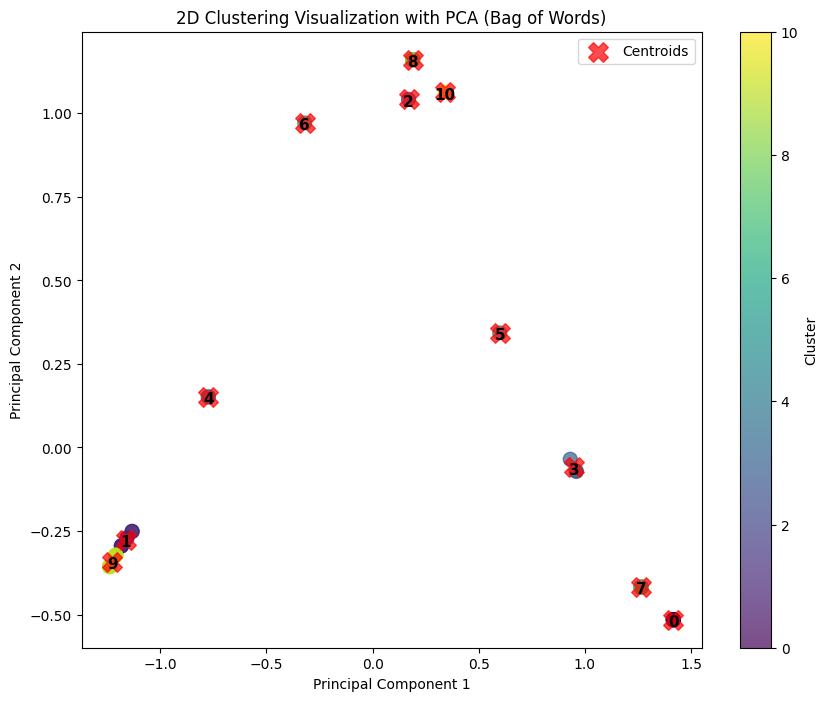

In [98]:

# Make a scatter plot with the centroids labeled as big red Xs
plt.figure(figsize=(10, 8))

# Scatter plot of the data points
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_kmeans, cmap='viridis', s=100, alpha=0.7)

# Scatter plot of the centroids
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=200, alpha=0.7, label='Centroids')

# Add cluster numbers on top of each centroid
for i, (x, y) in enumerate(kmeans.cluster_centers_):
    plt.text(x, y - 0.02, str(i), color='black', fontsize=11, ha='center', fontweight='bold')

# Add plot details
plt.title('2D Clustering Visualization with PCA (Bag of Words)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.colorbar(scatter, label='Cluster')
plt.show()

In [99]:

# Associate the labels with the sets of CSS styles
css_style_sets_dict = {label: style_set for label, style_set in zip(labels, styles)}

# Find common CSS properties for each cluster
common_properties = {}
for cluster, labels in clusters.items():
    
    # Get the style sets for all labels in the cluster
    style_sets = [css_style_sets_dict[label] for label in labels]
    
    # Find the intersection of all style sets in the cluster
    common_properties[cluster] = set.intersection(*style_sets)

In [100]:

# Display the common CSS properties for each cluster
print("Common CSS properties for each cluster:")
print('''
    <style
       type="text/css"
       id="style-wicked-elites">''')
for cluster, properties in common_properties.items():
    print(f'''      .cluster{cluster}-style {{''')
    for prop in sorted(properties):
        print(f"""        {prop.replace(':', ': ')};""")
    print('''      }''')
print('''    </style>''')

Common CSS properties for each cluster:

    <style
       type="text/css"
       id="style-wicked-elites">
      .cluster4-style {
        -inkscape-font-specification: 'Ink Free, Normal';
        font-family: 'Ink Free';
        font-size: 21.3333px;
        text-align: start;
      }
      .cluster9-style {
        -inkscape-font-specification: 'Ink Free, Normal';
        font-family: 'Ink Free';
        text-align: center;
      }
      .cluster5-style {
        stroke-dasharray: none;
        stroke-miterlimit: 4;
        stroke-width: 0.476692;
      }
      .cluster2-style {
        fill-opacity: 1;
        fill: #d0e095;
        stroke-dasharray: 0.264583, 1.5875;
        stroke-dashoffset: 0;
        stroke-width: 0.264583;
      }
      .cluster8-style {
        stroke-width: 0.264583px;
      }
      .cluster1-style {
        -inkscape-font-specification: 'Ink Free, Normal';
        font-family: 'Ink Free';
        text-align: center;
      }
      .cluster3-style {
        

In [101]:

# Print the labels regex grouped by cluster
print("Labels grouped by cluster:")
for cluster, labels in clusters.items():
    print()
    print(f'class="cluster{cluster}-style"')
    labels_str = '|'.join(sorted(labels))
    print(r'id="\b(' + labels_str + r')\b"')

Labels grouped by cluster:

class="cluster4-style"
id="\b(explanation-long-term|explanation-persecution)\b"

class="cluster9-style"
id="\b(explanation-blob|text-clientelism|text-doj|text-intimidation|text-long-term|text-persecution|text-short-term|text-swamp|text-the-admin-state)\b"

class="cluster5-style"
id="\b(path-long-term)\b"

class="cluster2-style"
id="\b(rect-intimidation)\b"

class="cluster8-style"
id="\b(path-blob|path-censorship|path-clientelism|path-persecution|path-politicians|path-propaganda)\b"

class="cluster1-style"
id="\b(text-blob|text-censorship|text-civil-society-institutions|text-media|text-politicians|text-private-corporations|text-propaganda)\b"

class="cluster3-style"
id="\b(circle-clientelism|circle-swamp|path-short-term)\b"

class="cluster10-style"
id="\b(path-civil-society-institutions)\b"

class="cluster7-style"
id="\b(circle-blob|circle-civil-society-institutions|circle-doj|circle-media|circle-politicians|circle-private-corporations|rect-the-admin-state)\b

In [103]:

# Display the common CSS properties regex for each cluster
for cluster, properties in common_properties.items():
    print()
    print(f'class="cluster{cluster}-style"')
    props_str = '|'.join(sorted(properties))
    print(r'(' + props_str + r');?')


class="cluster4-style"
(-inkscape-font-specification:'Ink Free, Normal'|font-family:'Ink Free'|font-size:21.3333px|text-align:start);?

class="cluster9-style"
(-inkscape-font-specification:'Ink Free, Normal'|font-family:'Ink Free'|text-align:center);?

class="cluster5-style"
(stroke-dasharray:none|stroke-miterlimit:4|stroke-width:0.476692);?

class="cluster2-style"
(fill-opacity:1|fill:#d0e095|stroke-dasharray:0.264583, 1.5875|stroke-dashoffset:0|stroke-width:0.264583);?

class="cluster8-style"
(stroke-width:0.264583px);?

class="cluster1-style"
(-inkscape-font-specification:'Ink Free, Normal'|font-family:'Ink Free'|text-align:center);?

class="cluster3-style"
(stroke-dasharray:none);?

class="cluster10-style"
(display:none|stroke-width:0.264583px);?

class="cluster7-style"
(fill:none|stroke-dasharray:none|stroke-width:0.529167);?

class="cluster0-style"
(display:none|fill:none|stroke-dasharray:none|stroke-width:0.529167);?

class="cluster6-style"
(-inkscape-font-specification:'Freest

In [104]:

# Print the labels grouped by cluster
print("Labels grouped by cluster:")
for cluster, labels in clusters.items():
    print()
    print(f"Cluster {cluster}:")
    for label in sorted(labels):
        print(f"  {label}")

Labels grouped by cluster:

Cluster 4:
  explanation-long-term
  explanation-persecution

Cluster 9:
  explanation-blob
  text-clientelism
  text-doj
  text-intimidation
  text-long-term
  text-persecution
  text-short-term
  text-swamp
  text-the-admin-state

Cluster 5:
  path-long-term

Cluster 2:
  rect-intimidation

Cluster 8:
  path-blob
  path-censorship
  path-clientelism
  path-persecution
  path-politicians
  path-propaganda

Cluster 1:
  text-blob
  text-censorship
  text-civil-society-institutions
  text-media
  text-politicians
  text-private-corporations
  text-propaganda

Cluster 3:
  circle-clientelism
  circle-swamp
  path-short-term

Cluster 10:
  path-civil-society-institutions

Cluster 7:
  circle-blob
  circle-civil-society-institutions
  circle-doj
  circle-media
  circle-politicians
  circle-private-corporations
  rect-the-admin-state

Cluster 0:
  circle-the-admin-state
  rect-east
  rect-north
  rect-south
  rect-west

Cluster 6:
  text-whole-of



----
# Try t-SNE

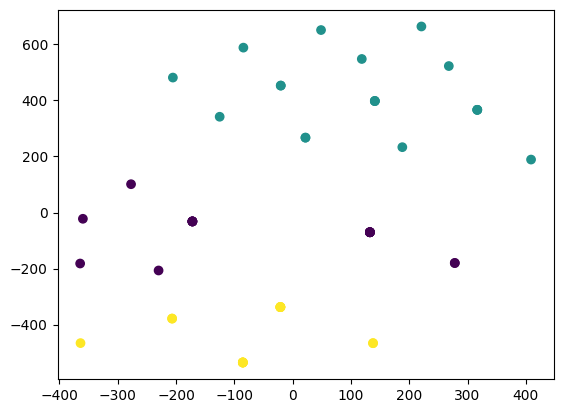

In [11]:

import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer

# Convert the CSS styles into numerical data
mlb = MultiLabelBinarizer()
styles_data = mlb.fit_transform(styles)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=0)
styles_2d = tsne.fit_transform(styles_data)

# Cluster the data
kmeans = KMeans(n_clusters=3, random_state=0)
clusters = kmeans.fit_predict(styles_2d)

# Create a 2D visualization of the clusters
plt.scatter(styles_2d[:, 0], styles_2d[:, 1], c=clusters)
plt.show()


----
# Try UMAP

In [6]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
import umap


## Step 1: Prepare the data

In [7]:

# Convert the list of sets of CSS styles into strings for vectorization
styles_strings = [';'.join(sorted(style)) for style in styles]

# Use Bag of Words (CountVectorizer) to vectorize the CSS styles
vectorizer = CountVectorizer(tokenizer=lambda x: x.split(';'), binary=True)
X = vectorizer.fit_transform(styles_strings).toarray()


## Step 2: Apply UMAP for dimensionality reduction

In [8]:

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
X_umap = reducer.fit_transform(X)


## Step 3: Perform clustering (e.g., K-Means)

In [9]:

# Adjust the number of clusters as needed
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
y_kmeans = kmeans.fit_predict(X_umap)


## Step 4: Visualize the UMAP-reduced data with clustering

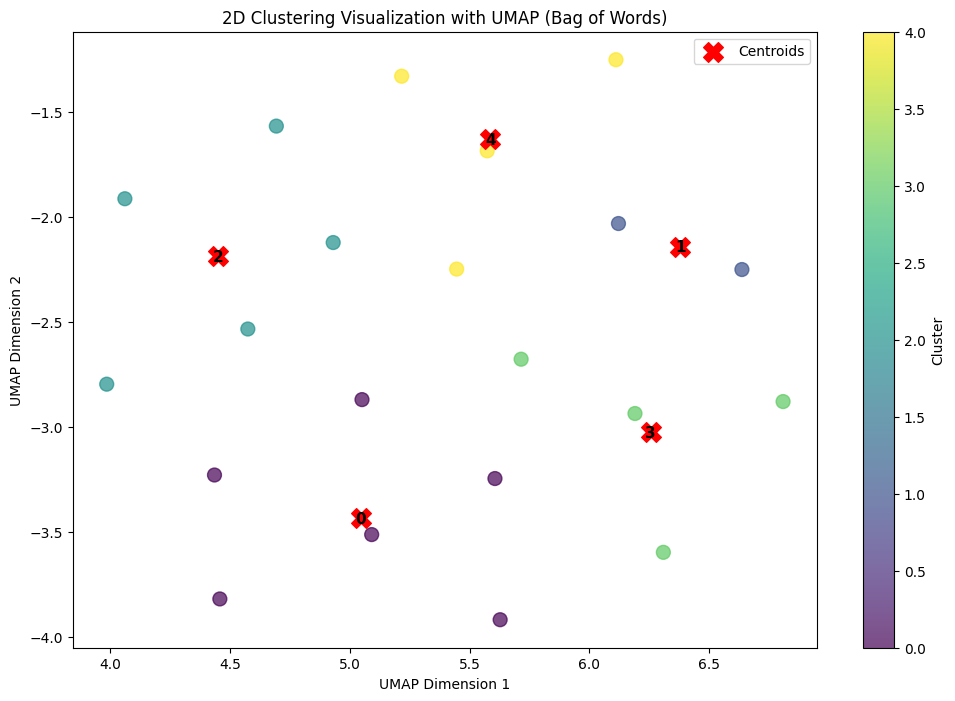

In [12]:

plt.figure(figsize=(12, 8))

# Scatter plot of the UMAP-reduced data points
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y_kmeans, cmap='viridis', s=100, alpha=0.7)

# Scatter plot of the cluster centroids
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroids')

# Add cluster numbers on top of each centroid
for i, (x, y) in enumerate(kmeans.cluster_centers_):
    plt.text(x, y - 0.025, str(i), color='black', fontsize=11, ha='center', fontweight='bold')

# Add plot details
plt.title('2D Clustering Visualization with UMAP (Bag of Words)')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend()
plt.colorbar(scatter, label='Cluster')
plt.show()